# Identification of risk markers by interpretability approach

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier 
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, \
                            confusion_matrix, accuracy_score, f1_score,recall_score
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold, cross_val_score, RepeatedKFold
import warnings
import pickle
import shap
shap.initjs()

warnings.filterwarnings('ignore')

In [2]:
"""Functions def"""
def read_data(raw_clinical_note):
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

def load_scaler(data,path):
    """Function for loading inverse_transform scaler"""
    scaler = pickle.load(open(path+'scaler','rb')) #load scaler
    np_array_rescale = scaler.inverse_transform(data)
    np_array_rescale = np.around(np_array_rescale,2)
    return np_array_rescale

def training(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=242)
  
    model = xgb.XGBClassifier(n_estimators=200,max_depth=5,gamma=2,subsample=0.3,
                              learning_rate = 0.03, objective = 'binary:logistic', 
                              seed = 422, eval_metric = "aucpr", reg_alpha= 0.03,
                              rate_drop = 0.3, scale_pos_weight = 6.127118644067797)
    model = model.fit(X_train,y_train) 
    return model

def plot_shap_values(model,patients,feature_list):
    """ Function for plotting global & local importances """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patients)
    plt.title("Global feature importance")
    shap.summary_plot(shap_values,  patients, feature_names=feature_list, plot_type='bar',max_display=10)
    plt.title("Local explanation summary")
    shap.summary_plot(shap_values, patients,feature_names=feature_list,show = 'False',max_display=10)

def plot_waterfall(model,X,id):   #,name,logs_file
    explainerModel_prob = shap.TreeExplainer(model,
                                   data = shap.sample(X, 50),
                                   model_output='probability')
    

    shap_values_model_prob  = explainerModel_prob.shap_values(X)
    
    shap.plots._waterfall.waterfall_legacy(explainerModel_prob.expected_value,
                                           shap_values_model_prob[id,:],
                                           X.iloc[id,:],show=False,max_display=12)

In [3]:
"""Loading sets"""
path = "C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/BCM/"
x_train = pd.read_csv(path+"X_train.csv")
y_train = pd.read_csv(path+"y_train.csv")
x_test = pd.read_csv(path+"X_test.csv")
y_test = pd.read_csv(path+"y_test.csv")

In [4]:
y_train.columns

Index(['Unnamed: 0', 'lethality'], dtype='object')

In [5]:
"""Dropping column"""
x_train = x_train.drop(['Unnamed: 0'],axis=1)
x_test = x_test.drop(['Unnamed: 0'],axis=1)
y_train = y_train['lethality']
y_test = y_test['lethality']
feature_list = x_train.columns

In [6]:
"""Loading scaler"""
x_train_normal = load_scaler(x_train,path)
x_test_normal = load_scaler(x_test,path)

x_train_normal = pd.DataFrame(x_train_normal,columns = feature_list)
x_test_normal = pd.DataFrame(x_test_normal,columns = feature_list)

y_train = pd.DataFrame(y_train, columns = ['lethality'])
y_test = pd.DataFrame(y_test, columns = ['lethality'])

In [7]:
x_test_normal

,Sex,Age,Fever,Cough,Odynophagia,Dyspnea,Irritability,Diarrhea,Chest pain,Chills,...,COPD,Asthma,Immunosuppression,Hypertension,Cardiovascular disease,Obesity,CKD,Smoking,Use of antipyretics,Days elapsed
0,1.0,62.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,1.0,0.0,2.0
1,0.0,51.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1.0,38.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,5.0
3,0.0,70.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.0,33.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,0.0,32.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,4.0
2309,1.0,56.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2310,0.0,52.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,3.0
2311,1.0,27.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
"""Concatenate (x_train , x_test)"""
X = pd.concat([x_train_normal,x_test_normal]).astype(int)
Y = pd.concat([y_train, y_test]).astype(int)
feature_list = X.columns

In [9]:
X

,Sex,Age,Fever,Cough,Odynophagia,Dyspnea,Irritability,Diarrhea,Chest pain,Chills,...,COPD,Asthma,Immunosuppression,Hypertension,Cardiovascular disease,Obesity,CKD,Smoking,Use of antipyretics,Days elapsed
0,1,28,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
1,0,55,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,50,0,1,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,3
3,1,26,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8
4,0,46,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,0,32,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
2309,1,56,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
2310,0,52,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3
2311,1,27,1,1,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1


In [10]:
Y

,lethality
0,0
1,0
2,0
3,0
4,0
...,...
2308,0
2309,0
2310,0
2311,0


In [11]:
"""Concatenate  both  sets"""
data_set = pd.concat([X,Y], axis=1)

data_set

In [12]:
data_set.shape[0]

11564

# Identification of risk markers for Morelos population

In [13]:
data_set.columns

Index(['Sex', 'Age', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed',
       'lethality'],
      dtype='object')

In [14]:
data_set['lethality'].value_counts()
print
Letality = np.where(data_set.lethality==1)
print("All (death):",Letality)

All (death): (array([    6,    33,    36, ..., 11543, 11548, 11563], dtype=int64),)


In [15]:
X = data_set.drop(['lethality'],axis=1)
y = data_set['lethality'].astype(int)
y = y.values.reshape(y.shape[0],1) 
feature_list = X.columns
print("X::", X.shape)
print("Y::", y.shape)

X:: (11564, 34)
Y:: (11564, 1)


In [16]:
model = training(X,y)

[12:32:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Population: (11564, 35)


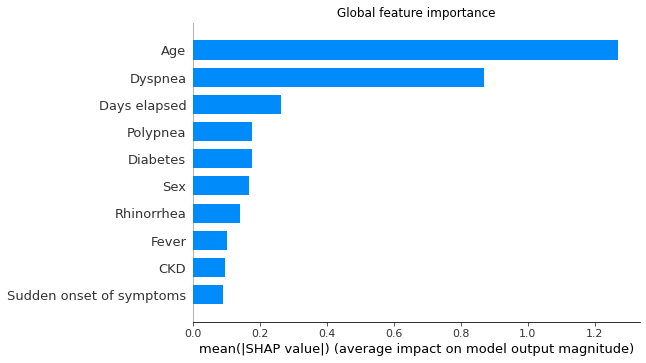

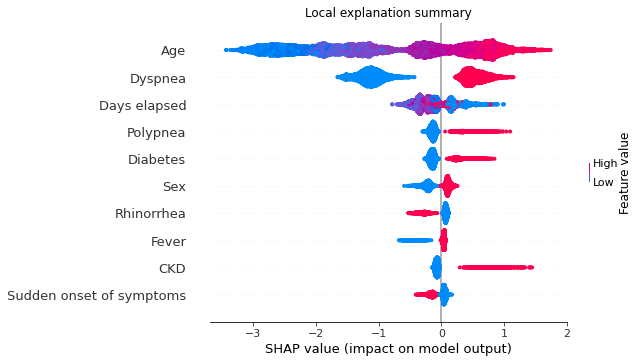

In [17]:
"""Risk markers for general population)"""
print("Population:",data_set.shape)
plot_shap_values(model,X,X.columns)

 99%|===================| 11481/11564 [00:55<00:00]        

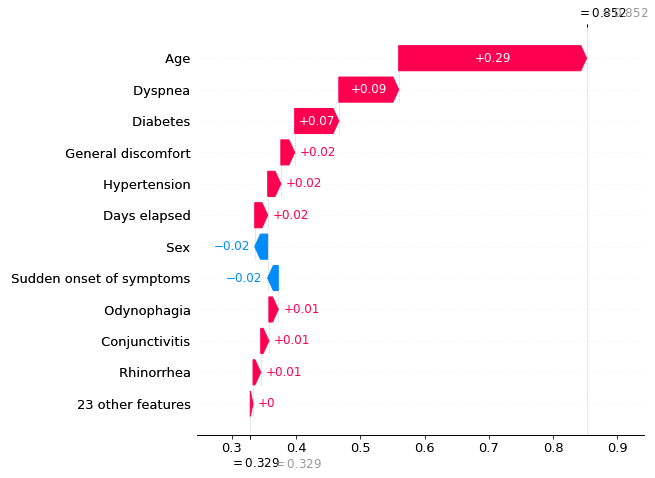

In [18]:
"""Individual explanation"""
id = 6
plot_waterfall(model,X,id) 
plt.savefig(path+'All patients id 6.pdf',bbox_inches='tight',)

# Identification of risk markers for males 

In [19]:
males = data_set[(data_set["Sex"]==1)]
X_males = males.drop(['Sex','Age','lethality'],axis=1)
feature_list_males = X_males.columns
y_males = males['lethality'].astype(int)
y_males = y_males.values.reshape(y_males.shape[0],1) 
print("Population:",X_males.shape)
print("Y::", y_males.shape)
print(feature_list_males)

Population: (6245, 32)
Y:: (6245, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [20]:
Letality_males = np.where(males.lethality==1)
print("All (death):",Letality_males)
males['lethality'].value_counts()

All (death): (array([  12,   14,   15, ..., 6230, 6231, 6244], dtype=int64),)


0    5161
1    1084
Name: lethality, dtype: int64

[12:33:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




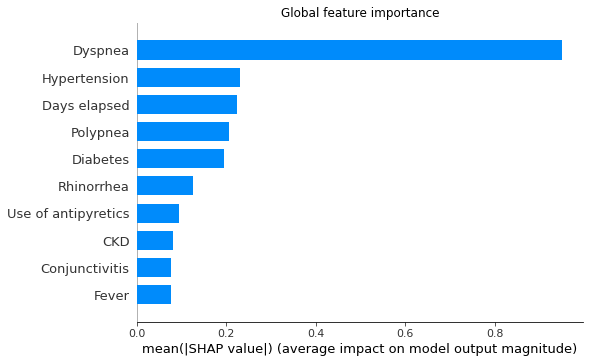

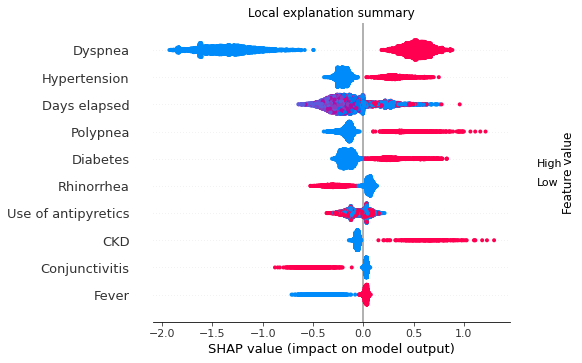

In [21]:
"""Risk markers for males"""
model_males = training(X_males,y_males)
plot_shap_values(model_males,X_males,X_males.columns)

 99%|===================| 6180/6245 [00:36<00:00]        

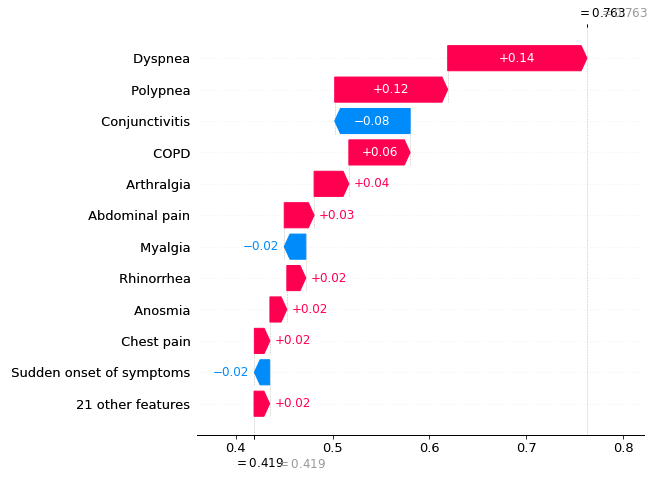

In [22]:
"""Individual explanation"""
id = 6230
plot_waterfall(model_males,X_males,id) 
plt.savefig(path+'All patients males id 6239.pdf',bbox_inches='tight',)

## Identification of risk markers for males aged 20 to 29

In [23]:
males_20_29 = males[(males["Age"]>=20) & ((males["Age"]<=29))]
X_males_20_29 = males_20_29.drop(['Sex','Age','lethality'],axis=1)
y_males_20_29 = males_20_29['lethality'].astype(int)
y_males_20_29 = y_males_20_29.values.reshape(y_males_20_29.shape[0],1)
feature_list_males_20_29 = X_males_20_29.columns
print("X::", X_males_20_29.shape)
print("Y::", y_males_20_29.shape)
print(feature_list_males_20_29)

X:: (657, 32)
Y:: (657, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [24]:
Letality_males_20_29 = np.where(males_20_29.lethality==1)
print("males 20-29 (death):",Letality_males_20_29)
males_20_29['lethality'].value_counts()

males 20-29 (death): (array([ 85, 107, 124, 128, 142, 172, 216, 251, 270, 293, 364, 438, 447,
       626], dtype=int64),)


0    643
1     14
Name: lethality, dtype: int64

[12:34:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




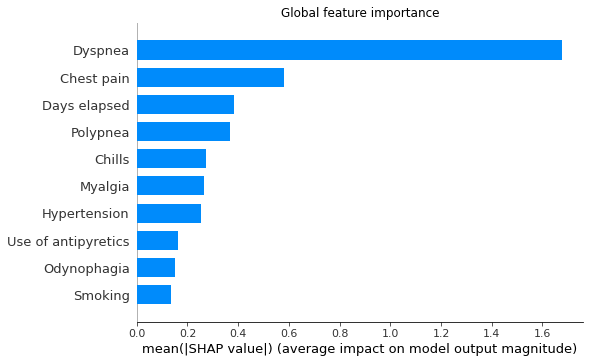

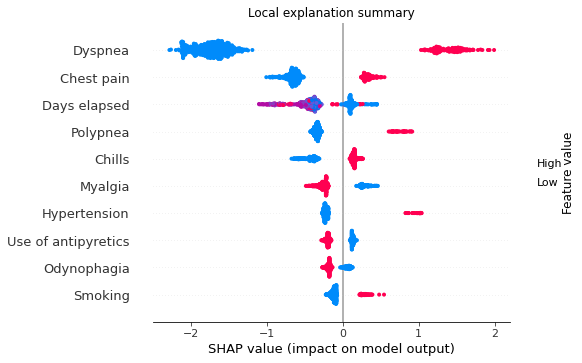

In [25]:
"""Risk markers for males (age from 20 to 29)"""
model_males_20_29 = training(X_males_20_29,y_males_20_29)
plot_shap_values(model_males_20_29,X_males_20_29,X_males_20_29.columns)

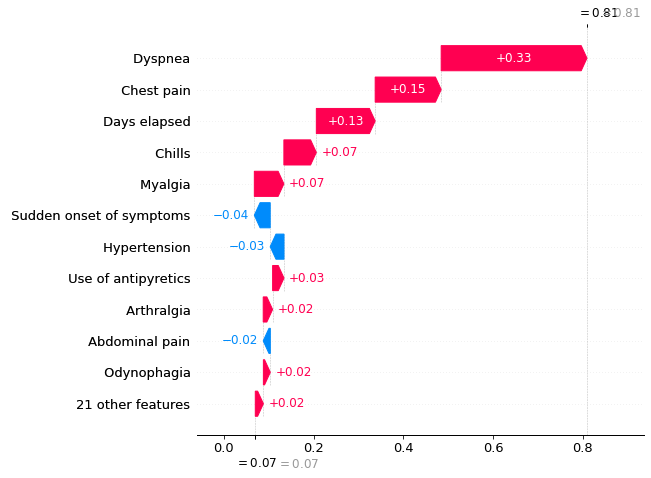

In [26]:
"""Individual explanation"""
id = 626
plot_waterfall(model_males_20_29,X_males_20_29,id) 
plt.savefig(path+'Patients males 20-29 id 626.pdf',bbox_inches='tight',)

## Identification of risk markers for males aged 30 to 39

In [27]:
males_30_39 = males[(males["Age"]>=30) & ((males["Age"]<=39))]
X_males_30_39 = males_30_39.drop(['Sex','Age','lethality'],axis=1)
y_males_30_39 = males_30_39['lethality'].astype(int)
y_males_30_39 = y_males_30_39.values.reshape(y_males_30_39.shape[0],1)
feature_list_males_30_39 = X_males_30_39.columns
print("X::", X_males_30_39.shape)
print("Y::", y_males_30_39.shape)
print(feature_list_males_30_39)

X:: (1091, 32)
Y:: (1091, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [28]:
Letality_males_30_39 = np.where(males_30_39.lethality==1)
print("males 30-39 (death):",Letality_males_30_39)
males_30_39['lethality'].value_counts()

males 30-39 (death): (array([   1,   17,   21,   58,   72,  107,  120,  131,  178,  196,  214,
        241,  271,  311,  334,  360,  376,  391,  411,  419,  468,  506,
        544,  579,  616,  627,  642,  645,  653,  733,  734,  830,  876,
        892,  952, 1024, 1053, 1081], dtype=int64),)


0    1053
1      38
Name: lethality, dtype: int64

[12:34:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




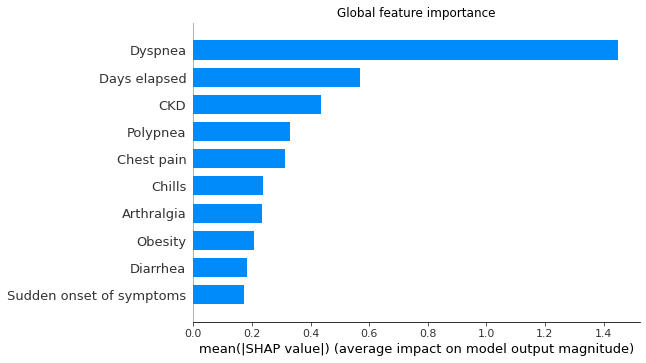

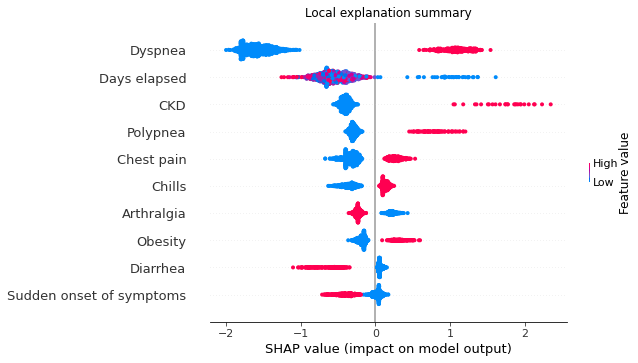

In [29]:
"""Risk markers for males (age from 30 to 39)"""
model_males_30_39 = training(X_males_30_39,y_males_30_39)
plot_shap_values(model_males_30_39,X_males_30_39,X_males_30_39.columns)

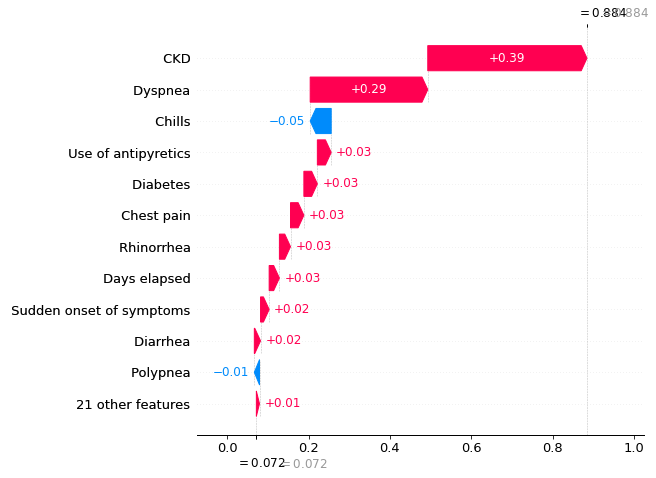

In [30]:
"""Individual explanation"""
id = 1
plot_waterfall(model_males_30_39,X_males_30_39,id) 
plt.savefig(path+'Patients males 30-39 id 1.pdf',bbox_inches='tight',)

## Identification of risk markers for males aged 40 to 49

In [31]:
males_40_49 = males[(males["Age"]>=40) & ((males["Age"]<=49))]
X_males_40_49 = males_40_49.drop(['Sex','Age','lethality'],axis=1)
y_males_40_49 = males_40_49['lethality'].astype(int)
y_males_40_49 = y_males_40_49.values.reshape(y_males_40_49.shape[0],1)
feature_list_males_40_49 = X_males_40_49.columns
print("X::", X_males_40_49.shape)
print("Y::", y_males_40_49.shape)
print(feature_list_males_40_49)

X:: (1149, 32)
Y:: (1149, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [32]:
Letality_males_40_49 = np.where(males_40_49.lethality==1)
print("males 30-39 (death):",Letality_males_40_49)
males_40_49['lethality'].value_counts()

males 30-39 (death): (array([  56,   65,   74,  104,  118,  127,  149,  153,  155,  159,  180,
        185,  186,  197,  201,  233,  264,  267,  269,  286,  288,  294,
        297,  302,  319,  326,  329,  347,  350,  355,  366,  376,  390,
        393,  397,  407,  430,  471,  472,  478,  484,  493,  502,  503,
        528,  537,  553,  567,  584,  585,  591,  599,  628,  642,  655,
        664,  692,  731,  733,  742,  744,  759,  765,  771,  772,  776,
        779,  781,  788,  792,  859,  864,  882,  884,  886,  916,  926,
        934,  957,  997, 1043, 1049, 1051, 1074, 1095, 1118, 1120, 1148],
      dtype=int64),)


0    1061
1      88
Name: lethality, dtype: int64

[12:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




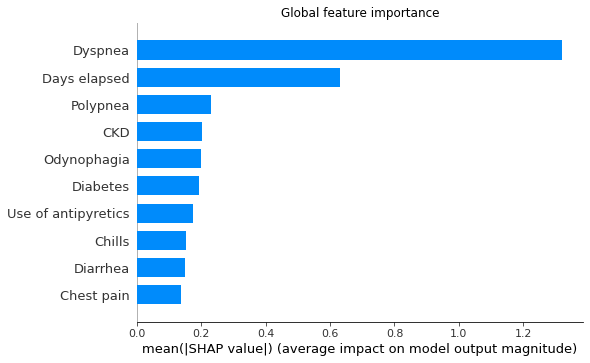

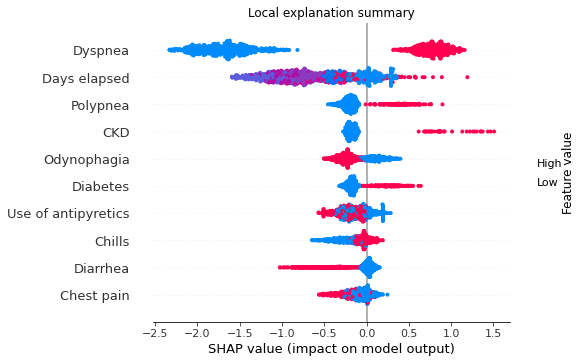

In [33]:
"""Risk markers for males (age from 40 to 49)"""
model_males_40_49 = training(X_males_40_49,y_males_40_49)
plot_shap_values(model_males_40_49,X_males_40_49,X_males_40_49.columns)

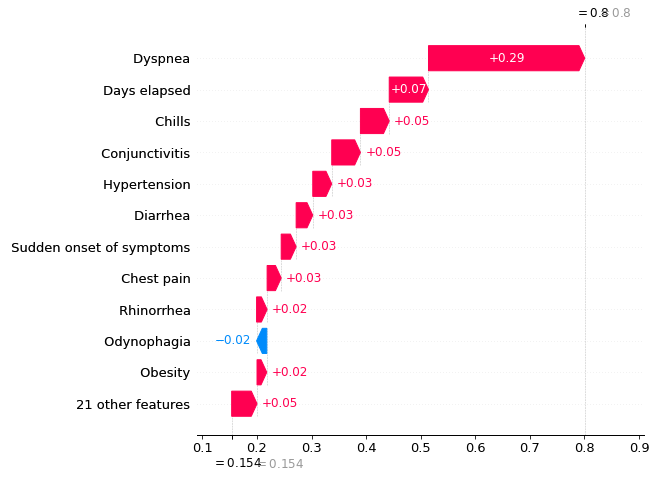

In [34]:
"""Individual explanation"""
id = 56
plot_waterfall(model_males_40_49,X_males_40_49,id) 
plt.savefig(path+'Patients males 40-49 id 56.pdf',bbox_inches='tight',)

## Identification of risk markers for males aged 50 to 59

In [35]:
males_50_59 = males[(males["Age"]>=50) & ((males["Age"]<=59))]
X_males_50_59 = males_50_59.drop(['Sex','Age','lethality'],axis=1)
y_males_50_59 = males_50_59['lethality'].astype(int)
y_males_50_59 = y_males_50_59.values.reshape(y_males_50_59.shape[0],1)
feature_list_males_50_59 = X_males_50_59.columns
print("X::", X_males_50_59.shape)
print("Y::", y_males_50_59.shape)
print(feature_list_males_50_59)

X:: (1150, 32)
Y:: (1150, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [36]:
Letality_males_50_59 = np.where(males_50_59.lethality==1)
print("males 50-59 (death):",Letality_males_50_59)
males_50_59['lethality'].value_counts()

males 50-59 (death): (array([  13,   14,   18,   21,   22,   24,   28,   38,   48,   54,   57,
         59,   83,   94,   96,   98,  100,  106,  121,  128,  130,  134,
        145,  152,  156,  159,  160,  162,  165,  169,  181,  194,  197,
        203,  205,  214,  217,  220,  222,  224,  227,  235,  239,  240,
        242,  250,  261,  267,  268,  281,  284,  285,  288,  289,  298,
        305,  308,  313,  322,  324,  333,  337,  339,  343,  348,  354,
        360,  384,  389,  398,  402,  410,  424,  429,  430,  432,  433,
        441,  442,  448,  451,  452,  456,  457,  461,  467,  471,  474,
        476,  480,  487,  494,  499,  503,  506,  520,  526,  557,  559,
        560,  561,  565,  572,  573,  584,  585,  586,  591,  613,  625,
        634,  640,  641,  643,  644,  646,  664,  678,  680,  689,  695,
        699,  700,  715,  721,  724,  730,  741,  743,  745,  748,  749,
        752,  754,  760,  762,  765,  771,  778,  784,  785,  786,  789,
        797,  799,  806,  807

0    947
1    203
Name: lethality, dtype: int64

[12:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




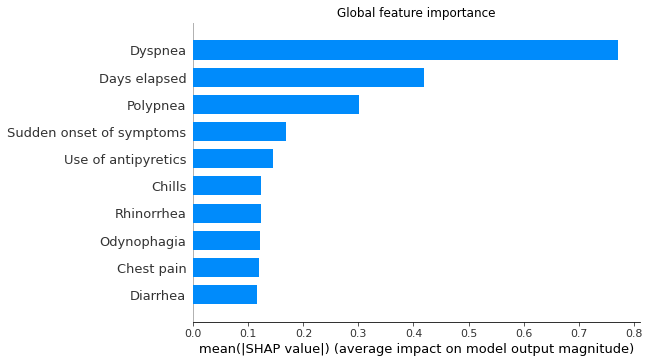

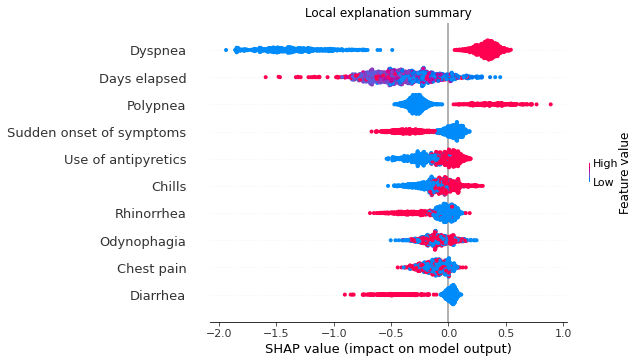

In [37]:
"""Risk markers for males (age from 50 to 59)"""
model_males_50_59 = training(X_males_50_59,y_males_50_59)
plot_shap_values(model_males_50_59,X_males_50_59,X_males_50_59.columns)

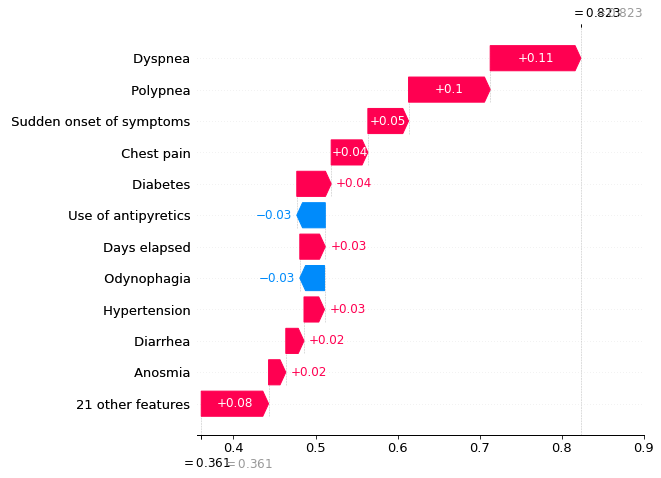

In [38]:
"""Individual explanation"""
id = 38
plot_waterfall(model_males_50_59,X_males_50_59,id) 
plt.savefig(path+'Patients males 50-59 id 38.pdf',bbox_inches='tight',)

## Identification of risk markers for males aged 60 to 69

In [39]:
males_60_69 = males[(males["Age"]>=60) & ((males["Age"]<=69))]
X_males_60_69 = males_60_69.drop(['Sex','Age','lethality'],axis=1)
y_males_60_69 = males_60_69['lethality'].astype(int)
y_males_60_69 = y_males_60_69.values.reshape(y_males_60_69.shape[0],1)
feature_list_males_60_69 = X_males_60_69.columns
print("X::", X_males_60_69.shape)
print("Y::", y_males_60_69.shape)
print(feature_list_males_60_69)

X:: (1034, 32)
Y:: (1034, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [40]:
Letality_males_60_69 = np.where(males_60_69.lethality==1)
print("males 60-69 (death):",Letality_males_60_69)
males_60_69['lethality'].value_counts()

males 60-69 (death): (array([   2,    4,    7,    9,   11,   13,   14,   15,   24,   25,   27,
         30,   32,   34,   36,   39,   41,   42,   43,   49,   51,   52,
         55,   67,   68,   70,   78,   80,   84,   87,   90,   93,   96,
        103,  107,  110,  113,  117,  119,  122,  123,  126,  127,  129,
        137,  140,  141,  146,  150,  151,  154,  155,  156,  167,  170,
        173,  178,  180,  182,  184,  185,  187,  189,  192,  193,  201,
        215,  220,  221,  223,  225,  226,  235,  237,  238,  240,  242,
        245,  250,  251,  255,  256,  281,  284,  286,  288,  292,  295,
        297,  298,  299,  302,  306,  309,  310,  311,  312,  314,  315,
        318,  322,  323,  324,  330,  331,  335,  341,  350,  353,  356,
        359,  361,  362,  364,  366,  368,  369,  374,  376,  377,  379,
        380,  394,  401,  403,  407,  408,  420,  423,  426,  427,  439,
        440,  442,  443,  444,  445,  447,  449,  457,  459,  460,  466,
        467,  469,  470,  474

0    724
1    310
Name: lethality, dtype: int64

[12:34:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




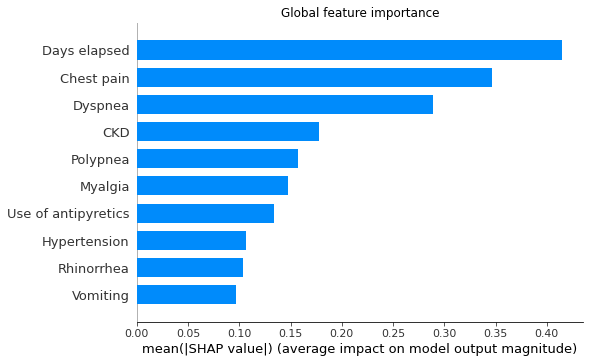

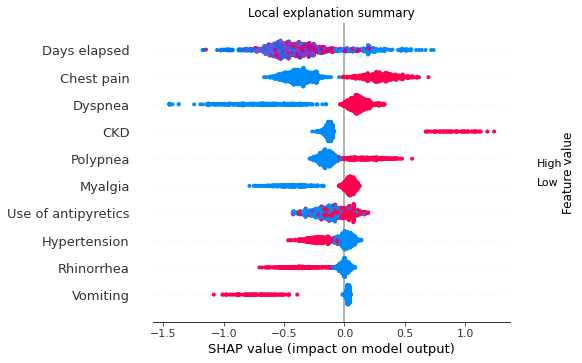

In [41]:
"""Risk markers for males (age from 60 to 69)"""
model_males_60_69 = training(X_males_60_69,y_males_60_69)
plot_shap_values(model_males_60_69,X_males_60_69,X_males_60_69.columns)

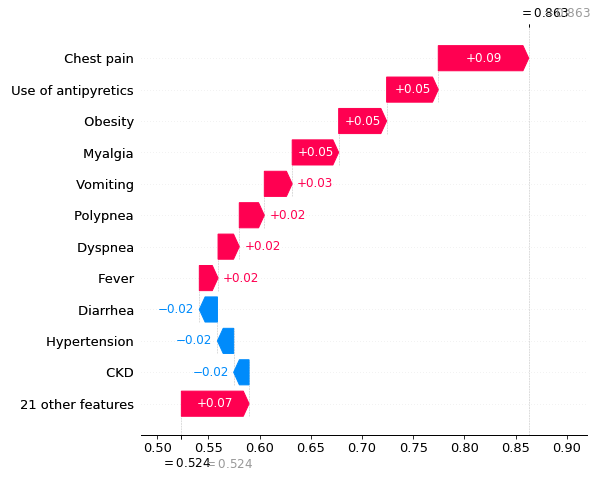

In [42]:
"""Individual explanation"""
id = 2
plot_waterfall(model_males_60_69,X_males_60_69,id) 
plt.savefig(path+'Patients males 60-69 id 2.pdf',bbox_inches='tight',)

## Identification of risk markers for males aged 70and over

In [43]:
males_70 = males[(males["Age"]>=70)]
X_males_70 = males_70.drop(['Sex','Age','lethality'],axis=1)
y_males_70 = males_70['lethality'].astype(int)
y_males_70 = y_males_70.values.reshape(y_males_70.shape[0],1)
feature_list_males_70 = X_males_70.columns
print("X::", X_males_70.shape)
print("Y::", y_males_70.shape)
print(feature_list_males_70)

X:: (1030, 32)
Y:: (1030, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [44]:
Letality_males_70 = np.where(males_70.lethality==1)
print("males 70 (death):",Letality_males_70)
males_70['lethality'].value_counts()

males 70 (death): (array([   0,    2,    4,    6,    8,   10,   11,   13,   16,   17,   22,
         27,   28,   30,   31,   33,   34,   37,   38,   40,   42,   44,
         47,   48,   54,   58,   59,   62,   63,   64,   65,   67,   68,
         70,   71,   75,   85,   88,   92,   97,  102,  103,  106,  108,
        111,  112,  114,  116,  118,  119,  122,  127,  128,  130,  132,
        133,  134,  136,  137,  141,  142,  143,  145,  152,  154,  158,
        163,  164,  166,  168,  169,  175,  176,  179,  180,  183,  184,
        185,  189,  190,  191,  197,  198,  199,  201,  203,  204,  206,
        208,  212,  213,  214,  215,  218,  220,  221,  222,  224,  227,
        231,  232,  233,  235,  236,  240,  248,  255,  256,  258,  263,
        265,  267,  268,  269,  271,  272,  276,  281,  282,  285,  286,
        288,  291,  297,  298,  300,  302,  303,  304,  306,  308,  310,
        312,  313,  316,  317,  318,  322,  323,  326,  327,  328,  329,
        334,  340,  342,  344,  

0    601
1    429
Name: lethality, dtype: int64

[12:34:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




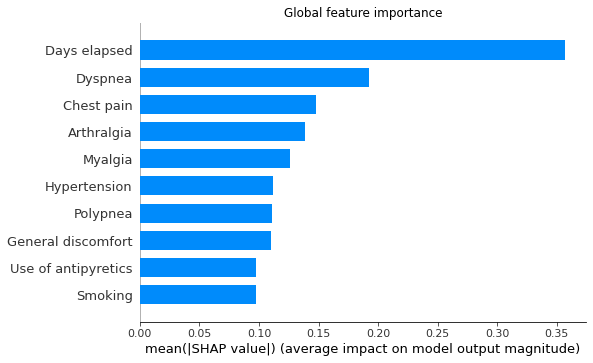

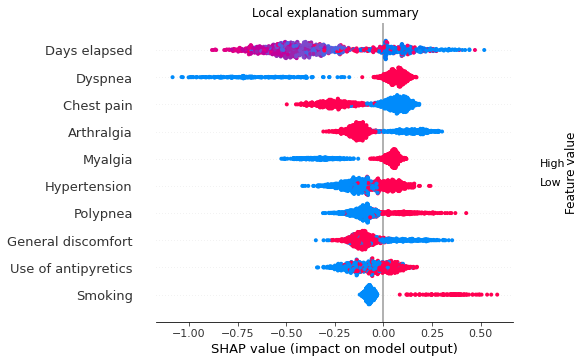

In [45]:
"""Risk markers for males (age from 70 and over)"""
model_males_70 = training(X_males_70,y_males_70)
plot_shap_values(model_males_70,X_males_70,X_males_70.columns)

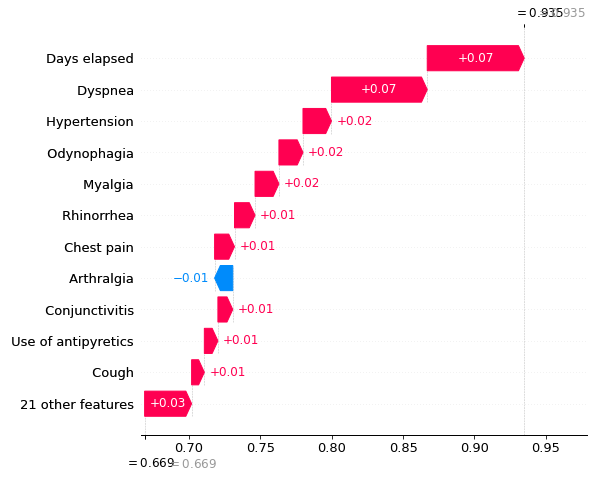

In [46]:
"""Individual explanation"""
id = 70
plot_waterfall(model_males_70,X_males_70,id) 
plt.savefig(path+'Patients males 70-79 id 70.pdf',bbox_inches='tight',)

# Identification of risk markers for females 

In [47]:
females = data_set[(data_set["Sex"]==0)]
X_females = females.drop(['Sex','Age','lethality'],axis=1)
feature_list_females = X_females.columns
y_females = females['lethality'].astype(int)
y_females = y_females.values.reshape(y_females.shape[0],1) 
print("Population:",X_females.shape)
print("Y::", y_females.shape)
print(feature_list_females)

Population: (5319, 32)
Y:: (5319, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [48]:
Letality_females = np.where(females.lethality==1)
print("females (death):",Letality_females)
females['lethality'].value_counts()

females (death): (array([   4,   22,   38,   67,   69,   70,   78,   83,   85,   86,   93,
         98,   99,  105,  137,  153,  157,  242,  249,  257,  269,  270,
        289,  294,  317,  345,  346,  350,  366,  375,  378,  380,  392,
        396,  397,  433,  451,  457,  486,  490,  520,  522,  523,  545,
        546,  558,  561,  573,  590,  594,  602,  604,  613,  614,  616,
        625,  636,  646,  647,  653,  658,  676,  717,  718,  720,  757,
        767,  768,  772,  777,  779,  782,  791,  793,  794,  806,  808,
        809,  811,  826,  836,  845,  850,  853,  863,  871,  896,  902,
        922,  932,  956,  963,  972,  980, 1001, 1007, 1008, 1009, 1023,
       1030, 1043, 1054, 1061, 1073, 1082, 1093, 1101, 1113, 1116, 1118,
       1126, 1136, 1137, 1144, 1159, 1166, 1191, 1204, 1207, 1214, 1215,
       1225, 1229, 1252, 1257, 1287, 1296, 1303, 1311, 1312, 1344, 1366,
       1367, 1379, 1386, 1396, 1401, 1453, 1456, 1462, 1471, 1482, 1531,
       1546, 1549, 1560, 1562, 15

0    4781
1     538
Name: lethality, dtype: int64

[12:34:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




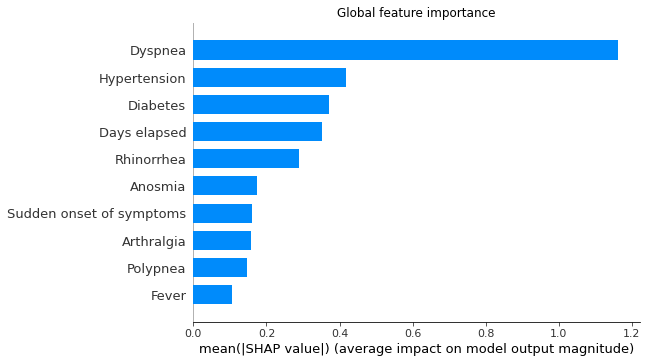

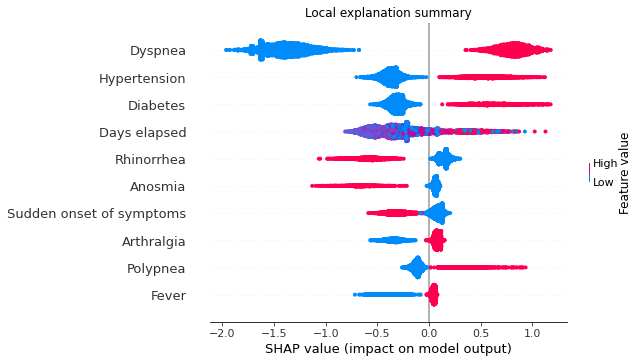

In [49]:
"""Risk markers for females"""
model_females = training(X_females,y_females)
plot_shap_values(model_females,X_females,X_females.columns)

 98%|===================| 5219/5319 [00:24<00:00]        

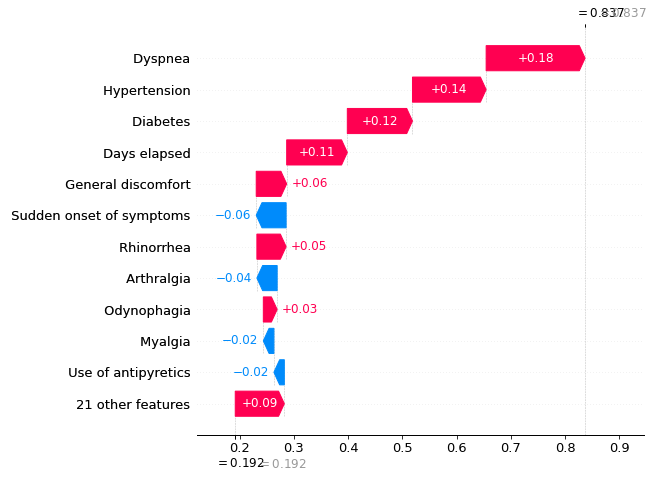

In [50]:
"""Individual explanation"""
id = 4
plot_waterfall(model_females,X_females,id) 
plt.savefig(path+'Patients females id 4.pdf',bbox_inches='tight',)

## Identification of risk markers for females aged 30 to 39

In [51]:
females_30_39 = females[(females["Age"]>=30) & ((females["Age"]<=39))]
X_females_30_39 = females_30_39.drop(['Sex','Age','lethality'],axis=1)
feature_list_females_30_39 = X_females_30_39.columns
y_females_30_39 = females_30_39['lethality'].astype(int)
y_females_30_39 = y_females_30_39.values.reshape(y_females_30_39.shape[0],1)
print("X::", X_females_30_39.shape)
print("Y::", y_females_30_39.shape)
print(feature_list_females_30_39)

X:: (1127, 32)
Y:: (1127, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [52]:
Letality_females_30_39 = np.where(females_30_39.lethality==1)
print("females 30-39 (death):",Letality_females_30_39)
females_30_39['lethality'].value_counts()

females 30-39 (death): (array([ 100,  118,  153,  192,  215,  224,  357,  506,  508,  518,  547,
        549,  625,  645,  652,  740,  818,  896, 1021, 1069], dtype=int64),)


0    1107
1      20
Name: lethality, dtype: int64

[12:35:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




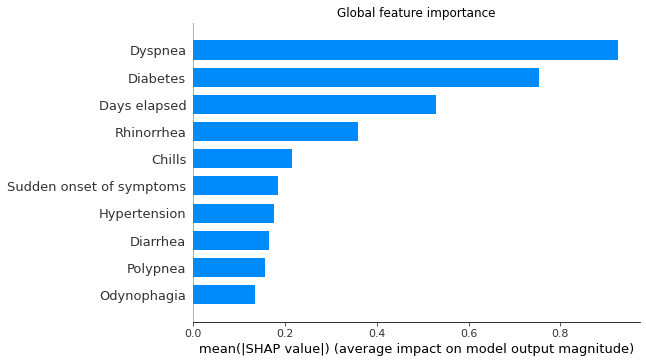

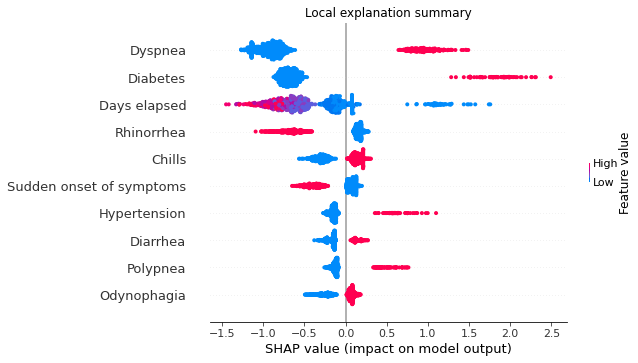

In [53]:
"""Risk markers for females (age from 30 to 39)"""
model_females_30_39 = training(X_females_30_39,y_females_30_39)
plot_shap_values(model_females_30_39,X_females_30_39,X_females_30_39.columns)

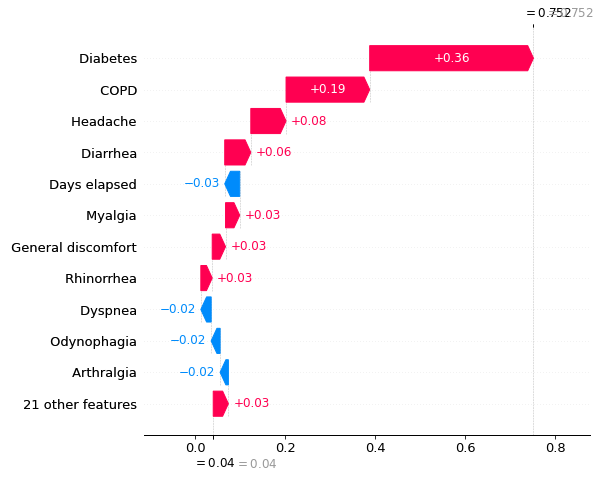

In [54]:
"""Individual explanation"""
id = 625
plot_waterfall(model_females_30_39,X_females_30_39,id) 
plt.savefig(path+'Patients females 30-39 id 625.pdf',bbox_inches='tight',)

## Identification of risk markers for females aged 40 to 49

In [55]:
females_40_49 = females[(females["Age"]>=40) & ((females["Age"]<=49))]
X_females_40_49 = females_40_49.drop(['Sex','Age','lethality'],axis=1)
y_females_40_49 = females_40_49['lethality'].astype(int)
y_females_40_49 = y_females_40_49.values.reshape(y_females_40_49.shape[0],1)
feature_list_females_40_49 = X_females_40_49.columns
print("X::", X_females_40_49.shape)
print("Y::", y_females_40_49.shape)
print(feature_list_females_40_49)

X:: (1072, 32)
Y:: (1072, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [56]:
Letality_females_40_49 = np.where(females_40_49.lethality==1)
print("females 40-49 (death):",Letality_females_40_49)
females_40_49['lethality'].value_counts()

females 40-49 (death): (array([   8,  130,  138,  155,  169,  214,  218,  241,  243,  301,  306,
        398,  428,  495,  530,  556,  572,  602,  612,  640,  656,  708,
        751,  812,  873,  879,  880,  898, 1012, 1054], dtype=int64),)


0    1042
1      30
Name: lethality, dtype: int64

[12:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




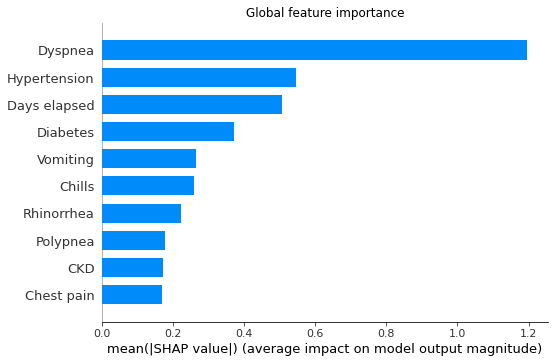

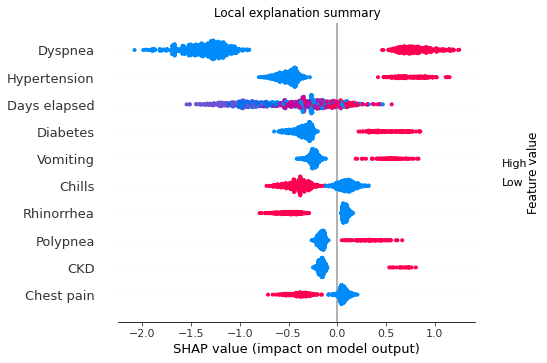

In [57]:
"""Risk markers for females (age from 40 to 49)"""
model_females_40_49 = training(X_females_40_49,y_females_40_49)
plot_shap_values(model_females_40_49,X_females_40_49,X_females_40_49.columns)

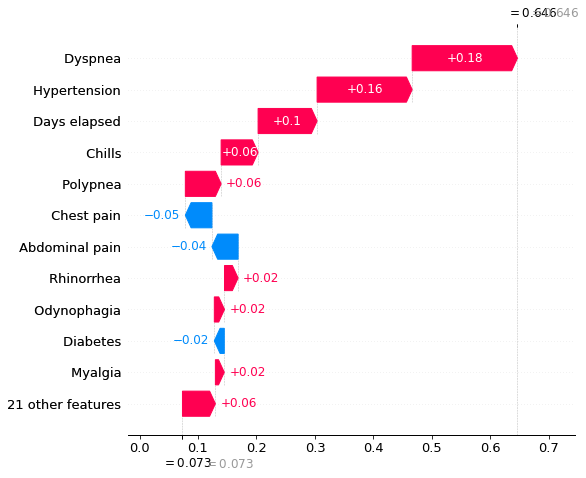

In [58]:
"""Individual explanation"""
id = 130
plot_waterfall(model_females_40_49,X_females_40_49,id) 
plt.savefig(path+'Patients females 40-49 id 130.pdf',bbox_inches='tight',)

## Identification of risk markers for females aged 50 to 59

In [59]:
females_50_59 = females[(females["Age"]>=50) & ((females["Age"]<=59))]
X_females_50_59 = females_50_59.drop(['Sex','Age','lethality'],axis=1)
y_females_50_59 = females_50_59['lethality'].astype(int)
y_females_50_59 = y_females_50_59.values.reshape(y_females_50_59.shape[0],1)
feature_list_females_50_59 = X_females_50_59.columns
print("X::", X_females_50_59.shape)
print("Y::", y_females_50_59.shape)
print(feature_list_females_50_59)

X:: (951, 32)
Y:: (951, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [60]:
Letality_females_50_59 = np.where(females_50_59.lethality==1)
print("females 50-59 (death):",Letality_females_50_59)
females_50_59['lethality'].value_counts()

females 50-59 (death): (array([ 17,  18,  21,  22,  25,  35,  58,  84,  90, 102, 106, 115, 120,
       144, 150, 152, 153, 158, 159, 172, 201, 206, 214, 215, 234, 235,
       271, 273, 314, 330, 331, 332, 337, 351, 367, 374, 389, 393, 394,
       404, 420, 427, 445, 446, 456, 462, 474, 479, 490, 517, 529, 549,
       554, 557, 558, 576, 581, 600, 609, 622, 628, 646, 647, 660, 661,
       674, 682, 690, 695, 708, 710, 719, 730, 740, 747, 767, 770, 777,
       783, 790, 796, 797, 807, 808, 824, 825, 827, 841, 849, 850, 853,
       866, 876, 880, 881, 882, 890, 895, 901, 906, 912, 914, 930, 939],
      dtype=int64),)


0    847
1    104
Name: lethality, dtype: int64

[12:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




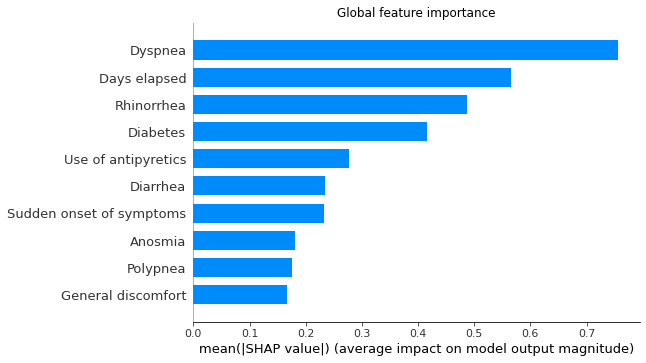

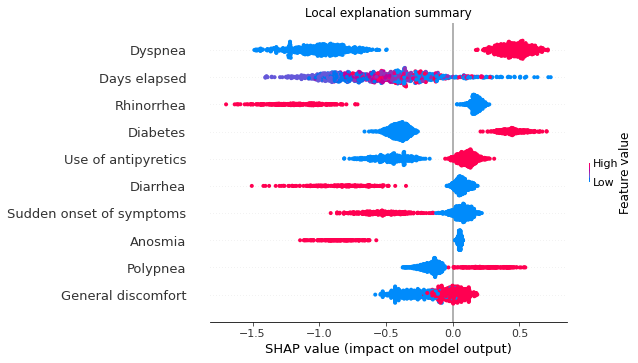

In [61]:
"""Risk markers for females (age from 50 to 59)"""
model_females_50_59 = training(X_females_50_59,y_females_50_59)
plot_shap_values(model_females_50_59,X_females_50_59,X_females_50_59.columns)

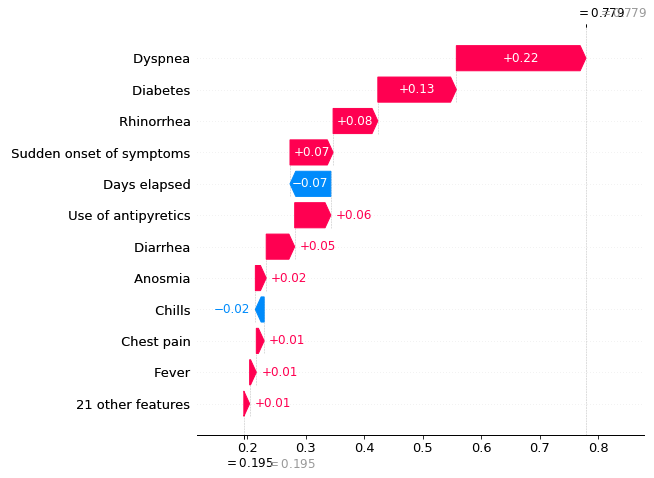

In [62]:
"""Individual explanation"""
id = 330
plot_waterfall(model_females_50_59,X_females_50_59,id) 
plt.savefig(path+'Patients females 50-59 id 330.pdf',bbox_inches='tight',)

## Identification of risk markers for females aged 60 to 69

In [63]:
females_60_69 = females[(females["Age"]>=60) & ((females["Age"]<=69))]
X_females_60_69 = females_60_69.drop(['Sex','Age','lethality'],axis=1)
y_females_60_69 = females_60_69['lethality'].astype(int)
y_females_60_69 = y_females_60_69.values.reshape(y_females_60_69.shape[0],1)
feature_list_females_60_69 = X_females_60_69.columns
print("X::", X_females_60_69.shape)
print("Y::", y_females_60_69.shape)
print(feature_list_females_60_69)

X:: (700, 32)
Y:: (700, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [64]:
Letality_females_60_69 = np.where(females_60_69.lethality==1)
print("females 60-69 (death):",Letality_females_60_69)
females_60_69['lethality'].value_counts()

females 60-69 (death): (array([  5,   6,  20,  30,  33,  37,  41,  48,  49,  54,  59,  60,  64,
        72,  73,  75,  86, 100, 101, 107, 108, 110, 111, 115, 138, 139,
       153, 156, 163, 167, 178, 184, 185, 198, 199, 200, 201, 206, 209,
       211, 216, 222, 225, 227, 231, 233, 237, 240, 243, 245, 249, 252,
       253, 257, 259, 261, 269, 276, 281, 282, 283, 287, 312, 314, 320,
       321, 326, 329, 333, 335, 336, 339, 345, 350, 351, 359, 360, 365,
       368, 369, 372, 373, 375, 382, 385, 392, 399, 400, 403, 408, 411,
       412, 415, 418, 420, 423, 427, 438, 443, 445, 447, 449, 451, 454,
       456, 457, 470, 476, 481, 487, 489, 493, 498, 502, 506, 512, 513,
       519, 522, 525, 530, 534, 535, 536, 540, 541, 542, 547, 549, 552,
       556, 558, 559, 561, 570, 573, 574, 575, 581, 583, 584, 588, 596,
       600, 606, 612, 620, 621, 623, 624, 628, 632, 635, 642, 647, 648,
       656, 670, 675, 682, 685, 692, 694, 699], dtype=int64),)


0    536
1    164
Name: lethality, dtype: int64

[12:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




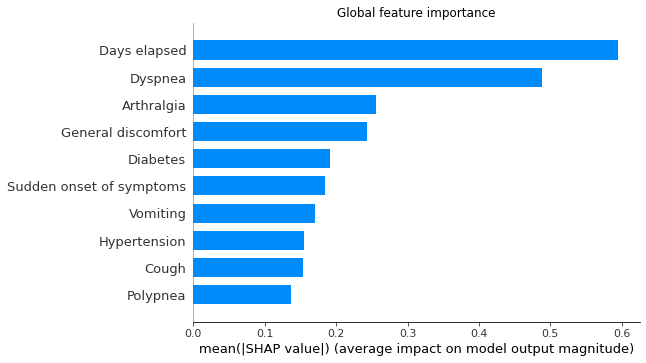

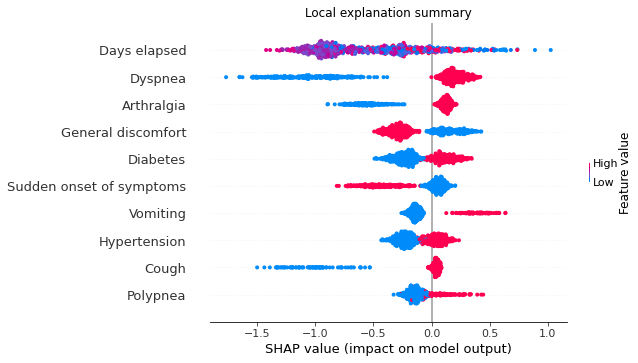

In [65]:
"""Risk markers for females (age from 60 to 69)"""
model_females_60_69 = training(X_females_60_69,y_females_60_69)
plot_shap_values(model_females_60_69,X_females_60_69,X_females_60_69.columns)

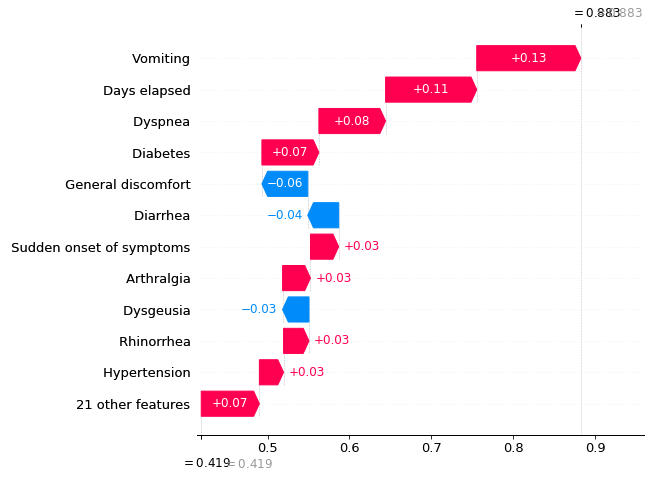

In [66]:
"""Individual explanation"""
id = 536
plot_waterfall(model_females_60_69,X_females_60_69,id) 
plt.savefig(path+'Patients females 60-69 id 536.pdf',bbox_inches='tight',)

## Identification of risk markers for females aged 70and over

In [67]:
females_70 = females[(females["Age"]>=70)]
X_females_70 = females_70.drop(['Sex','Age','lethality'],axis=1)
y_females_70 = females_70['lethality'].astype(int)
y_females_70 = y_females_70.values.reshape(y_females_70.shape[0],1)
feature_list_females_70 = X_females_70.columns
print("X::", X_females_70.shape)
print("Y::", y_females_70.shape)
print(feature_list_females_70)

X:: (633, 32)
Y:: (633, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [68]:
Letality_females_70 = np.where(females_70.lethality==1)
print("females 70 (death):",Letality_females_70)
females_70['lethality'].value_counts()

females 70 (death): (array([  0,   3,   7,   9,  10,  11,  16,  23,  26,  30,  35,  36,  37,
        38,  40,  41,  48,  52,  56,  59,  61,  62,  63,  66,  68,  69,
        70,  74,  82,  85,  86,  90,  96,  98,  99, 102, 103, 106, 113,
       115, 116, 119, 120, 123, 124, 126, 130, 133, 135, 137, 145, 148,
       150, 157, 158, 159, 161, 164, 168, 171, 174, 177, 183, 184, 185,
       188, 192, 194, 195, 196, 197, 199, 202, 203, 207, 213, 216, 223,
       224, 225, 227, 228, 231, 232, 238, 240, 244, 248, 254, 255, 256,
       261, 264, 265, 271, 272, 273, 274, 275, 276, 282, 285, 286, 288,
       295, 296, 300, 304, 306, 324, 325, 327, 329, 331, 333, 336, 337,
       338, 339, 340, 343, 344, 349, 352, 353, 357, 359, 360, 363, 367,
       369, 380, 384, 386, 387, 388, 390, 394, 396, 401, 402, 408, 414,
       417, 423, 426, 427, 428, 429, 433, 438, 440, 442, 447, 449, 454,
       455, 457, 458, 460, 461, 470, 473, 478, 480, 484, 487, 493, 497,
       499, 500, 516, 517, 518, 519, 521, 5

0    416
1    217
Name: lethality, dtype: int64

[12:35:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




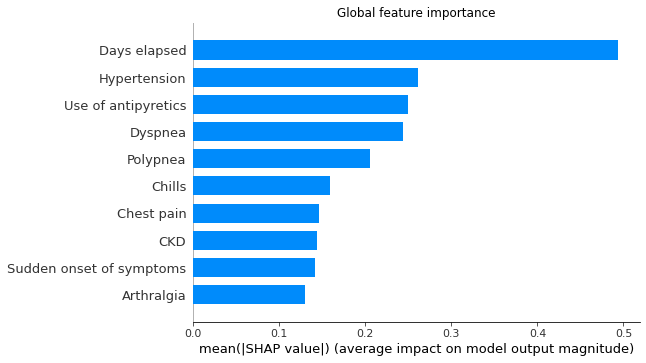

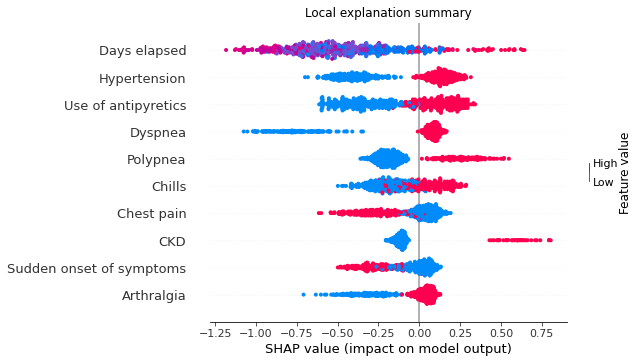

In [69]:
"""Risk markers for females (age from 70 to 79)"""
model_females_70 = training(X_females_70,y_females_70)
plot_shap_values(model_females_70,X_females_70,X_females_70.columns)

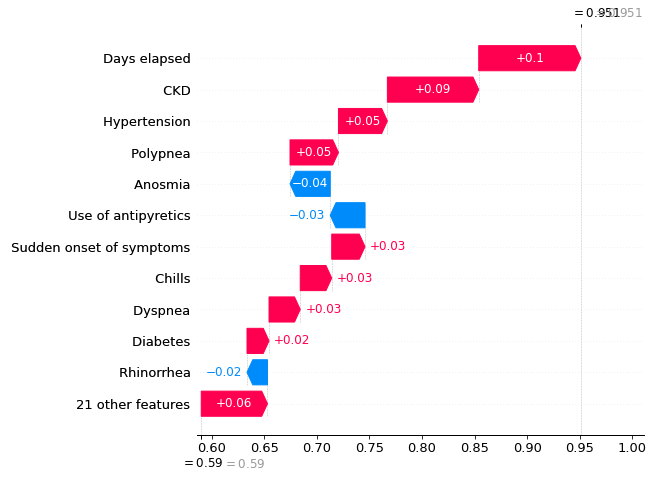

In [70]:
"""Individual explanation"""
id = 62
plot_waterfall(model_females_70,X_females_70,id) 
plt.savefig(path+'Patients females 70 id 62.pdf',bbox_inches='tight',)